# Random Forest Implementation

### PreProcess Data

In [2]:
import PreProcessData as pre
import imp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
imp.reload(pre)
X_train, X_valid, y_train, y_valid = pre.PreProcessData()
y_valid = [0 if int(y) == 2 or int(y) == 3 else y for y in y_valid]
y_valid = np.array(y_valid)
y_valid = y_valid.reshape(-1,1)
# print(X_train)

/tmp/ipykernel_161481/3811603676.py:2: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


### Class Construction

In [3]:
class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        num_class = len(np.unique(y))

        # Check termination conditions
        if depth == self.max_depth or num_class == 1:
            return np.bincount(y).argmax()

        # Find the best split
        best_split = self._find_best_split(X, y)

        if best_split['impurity'] == 0:
            return np.bincount(y).argmax()

        left_indices = X[:, best_split['feature_index']] <= best_split['threshold']
        right_indices = ~left_indices

        # Recursively build the left and right subtrees
        left_subtree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return {'feature_index': best_split['feature_index'],
                'threshold': best_split['threshold'],
                'left': left_subtree,
                'right': right_subtree}

    def _calculate_gini(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        gini = 1 - np.sum(probabilities ** 2)
        return gini

    def _find_best_split(self, X, y):
        num_samples, num_features = X.shape
        best_split = {'impurity': 0}
        best_gini = float('inf')

        for feature_index in range(num_features):
            thresholds = np.unique(X[:, feature_index])

            for threshold in thresholds:
                left_indices = X[:, feature_index] <= threshold
                right_indices = ~left_indices

                if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
                    continue

                left_gini = self._calculate_gini(y[left_indices])
                right_gini = self._calculate_gini(y[right_indices])

                gini = (len(y[left_indices]) / num_samples) * left_gini \
                       + (len(y[right_indices]) / num_samples) * right_gini

                if gini < best_gini:
                    best_split = {'feature_index': feature_index,
                                  'threshold': threshold,
                                  'impurity': gini}
                    best_gini = gini

        return best_split

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.tree) for x in X])

    def _traverse_tree(self, x, node):
        if isinstance(node, int):
            return node

        if isinstance(node, dict):
            if x[node['feature_index']] <= node['threshold']:
                return self._traverse_tree(x, node['left'])
            else:
                return self._traverse_tree(x, node['right'])
        else:
            # If the node is not a dictionary, return it as it is
            return node



class RandomForest:
    def __init__(self, n_estimators=10, max_depth=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.estimators = []

    def fit(self, X, y):
        self.estimators = []
        for _ in range(self.n_estimators):
            # Create a decision tree
            tree = DecisionTree(max_depth=self.max_depth)
            
            # Randomly sample the data with replacement
            sample_indices = np.random.choice(len(X), size=len(X), replace=True)
            X_sampled = X[sample_indices]
            y_sampled = y[sample_indices]
            
            # Fit the decision tree on the sampled data
            tree.fit(X_sampled, y_sampled)
            
            # Append the decision tree to the list of estimators
            self.estimators.append(tree)

    def predict(self, X):
        # Make predictions using each decision tree and take the majority vote
        predictions = np.array([tree.predict(X) for tree in self.estimators])
        return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)

    def validate(self, y_pred, y_valid):
        num_of_correct_predictions = 0
        for i in range(len(y_valid)):
            if y_pred[i] == y_valid[i]:
                num_of_correct_predictions += 1
        accuracy = num_of_correct_predictions / len(y_valid)
        return accuracy

    def plot(self, y_pred, y_valid):
        y_pred = [0 if y < 0.5 else 1 for y in y_pred]
        # Calculate confusion matrix
        cm = confusion_matrix(y_valid, y_pred)

        # Define labels for the confusion matrix
        labels = [['True Negative', 'False Positive'], ['False Negative', 'True Positive']]

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

        # Annotate cells with labels
        for i in range(2):
            for j in range(2):
                plt.text(j + 0.5, i + 0.3, labels[i][j], ha='center', va='center', color='red')

        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix with Labels')
        plt.show()


### Forest with 3 Trees Depth 2

In [16]:
forest2 = RandomForest(n_estimators=3, max_depth=2)
forest2.fit(np.array(X_train), np.array(y_train))
predictions2 = forest2.predict(np.array(X_valid))
print(forest2.validate(predictions2, y_valid))

0.6709200805910007


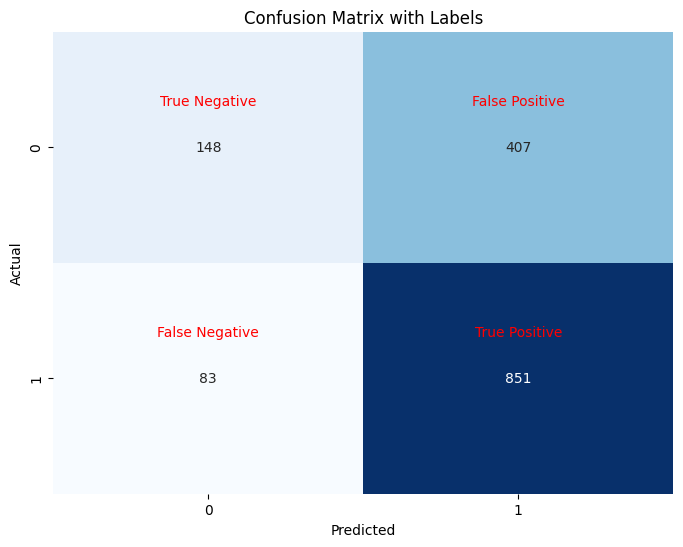

In [17]:
forest2.plot(predictions2, y_valid)

### Forest with 3 Trees Depth 3

In [18]:
forest3 = RandomForest(n_estimators=3, max_depth=3)
forest3.fit(np.array(X_train), np.array(y_train))
predictions3 = forest3.predict(np.array(X_valid))
print(forest3.validate(predictions3, y_valid))

0.6863666890530558


Higher depth of trees leads to higher accuracy so far

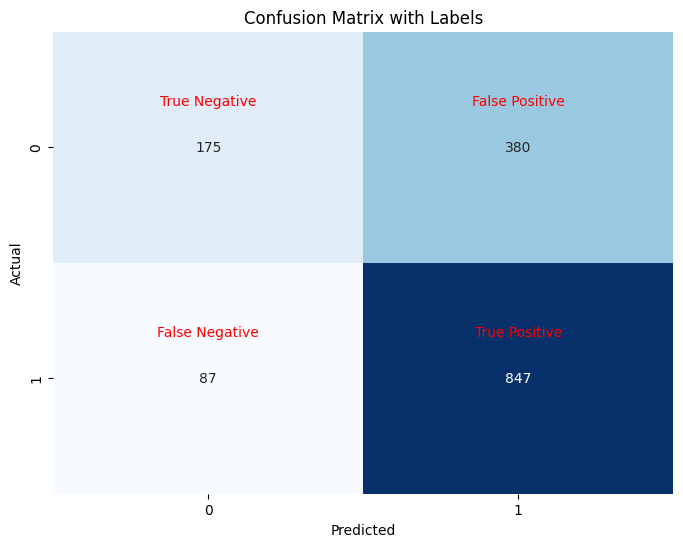

In [19]:
forest3.plot(predictions3, y_valid)

### Forest with 3 Trees Depth 7

In [20]:
forest7 = RandomForest(n_estimators=3, max_depth=7)
forest7.fit(np.array(X_train), np.array(y_train))
predictions7 = forest7.predict(np.array(X_valid))
print(forest7.validate(predictions7, y_valid))

0.7051712558764271


We will have the Decision Tree best proformer, depth of 7, and three of them perform a better than the previous depth of three.

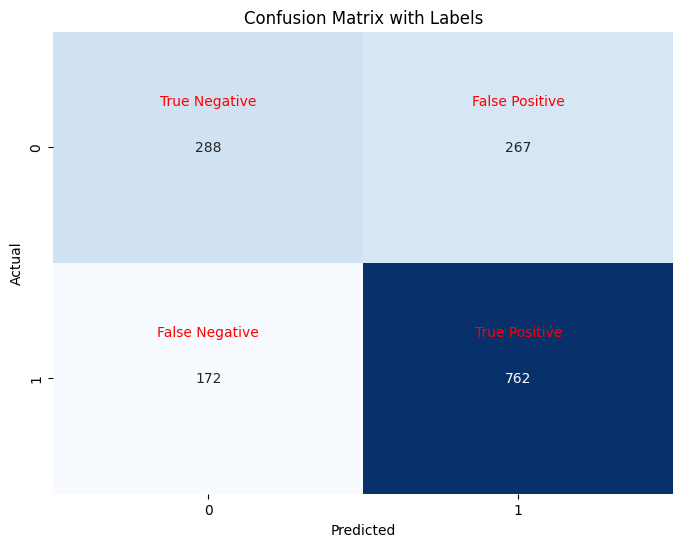

In [21]:
forest7.plot(predictions7, y_valid)

### Forest with 5 Trees Depth 7

In [25]:
forest75 = RandomForest(n_estimators=5, max_depth=7)
forest75.fit(np.array(X_train), np.array(y_train))
predictions75 = forest75.predict(np.array(X_valid))
print(forest75.validate(predictions75, y_valid))

0.712558764271323


Given more more trees, 5, we have a higher accuracy of 71.2%. 0.8% better than the previous.

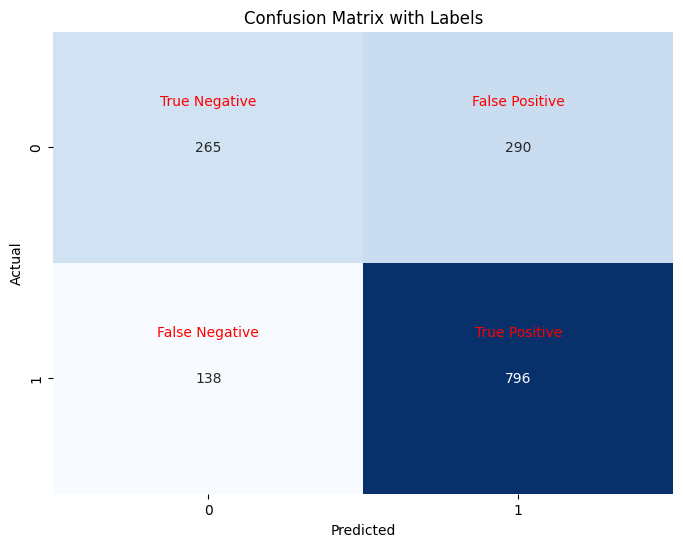

In [32]:
forest75.plot(predictions75, y_valid)

### Forest with 7 Trees Depth 7

In [26]:
forest77 = RandomForest(n_estimators=7, max_depth=7)
forest77.fit(np.array(X_train), np.array(y_train))
predictions77 = forest77.predict(np.array(X_valid))
print(forest77.validate(predictions77, y_valid))

0.7286769644056413


Given 7 trees we get an even higher accuracy at 72.8% and this model is 1.6% better than the previous.

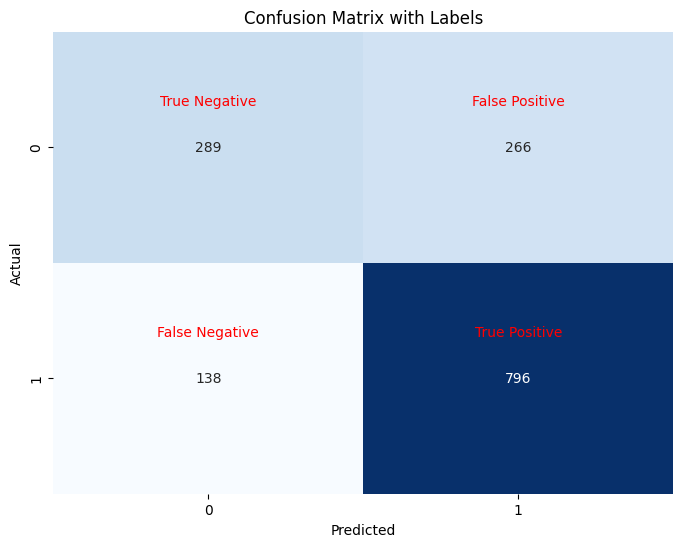

In [36]:
forest77.plot(predictions77, y_valid)

### Forest with 9 Trees Depth 7

In [18]:
forest79 = RandomForest(n_estimators=9, max_depth=7)
forest79.fit(np.array(X_train), np.array(y_train))
predictions79 = forest79.predict(np.array(X_valid))
print(forest79.validate(predictions79, y_valid))

0.7199462726662189


Given 9 trees the model is doing 1% worse. Could be the start of the true risk going up and empirical risk going down. Could also be a random unlucky batch.

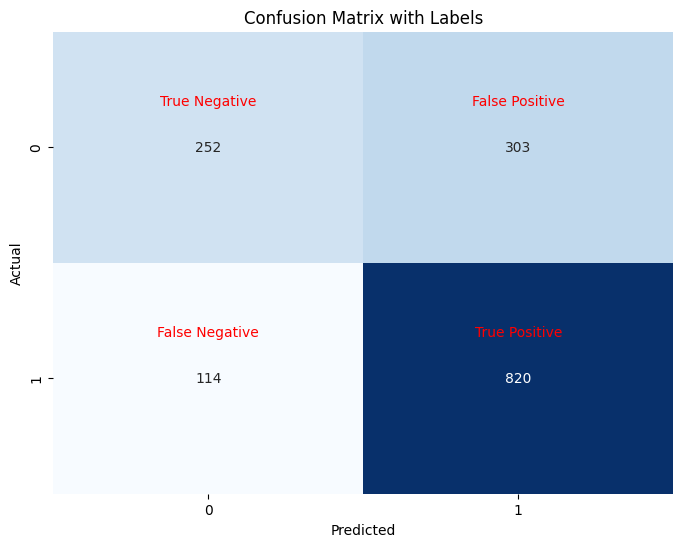

In [19]:
forest79.plot(predictions79, y_valid)

### Forest with 8 Trees Depth 7

In [20]:
forest78 = RandomForest(n_estimators=8, max_depth=7)
forest78.fit(np.array(X_train), np.array(y_train))
predictions78 = forest78.predict(np.array(X_valid))
print(forest78.validate(predictions78, y_valid))

0.7259905977165884


Does a little worse than the best model so far, 7 trees with 7 depth by around 0.2%.

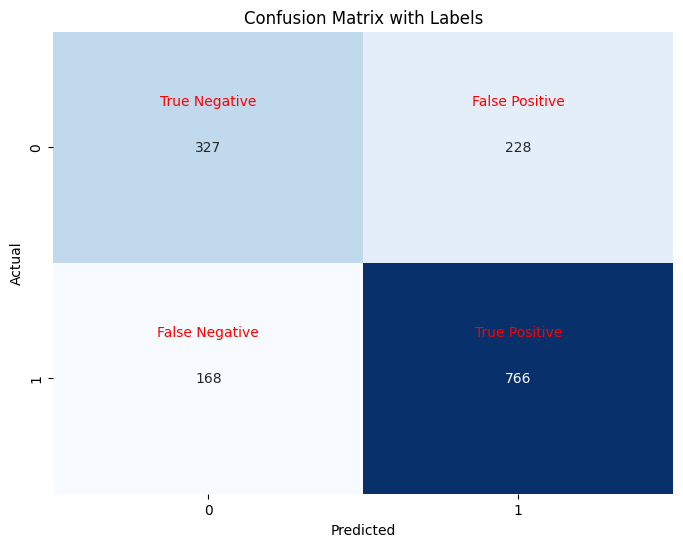

In [34]:
forest78.plot(predictions78, y_valid)

### Forest with 10 Trees Depth 7

In [22]:
forest710 = RandomForest(n_estimators=10, max_depth=7)
forest710.fit(np.array(X_train), np.array(y_train))
predictions710 = forest710.predict(np.array(X_valid))
print(forest710.validate(predictions710, y_valid))

0.7266621893888516


This 10 tree depth 7 model is 0.6% better than the previous but still not the best

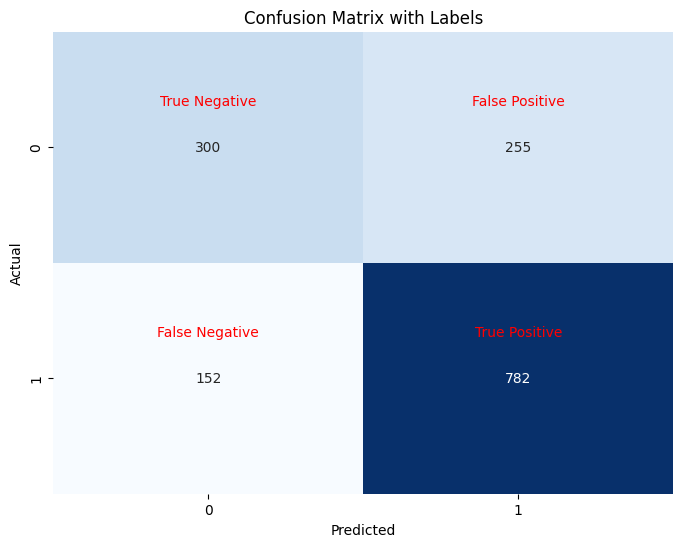

In [23]:
forest710.plot(predictions710, y_valid)

### MAKE A BIG FOREST!

In [5]:
forestBIG = RandomForest(n_estimators=30, max_depth=7)
forestBIG.fit(np.array(X_train), np.array(y_train))
predictionsBIG = forestBIG.predict(np.array(X_valid))
print(forestBIG.validate(predictionsBIG, y_valid))

0.7239758226997985


A little worse than the previous model, but probably more consistant with the accuracy percentage of 72.3%

In [ ]:
forestBIG.plot(predictionsBIG, y_valid)